#### RESNET50 Transfer Learning Implementation on the MNIST-HAM10000 Dataset 
- We will utilize the pre-trained ResNet50 CNN Model in order to carry out diagnosis on the image data exclusively.
- The ResNet50 implementation will yield a more accurate model but will be heavy.

In [2]:
#Import Libraries
import tensorflow as tf 
import keras as K 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats

##### Carry out preliminary data analysis
- Plot distribution of categories in metadata.
- Print metadata information.

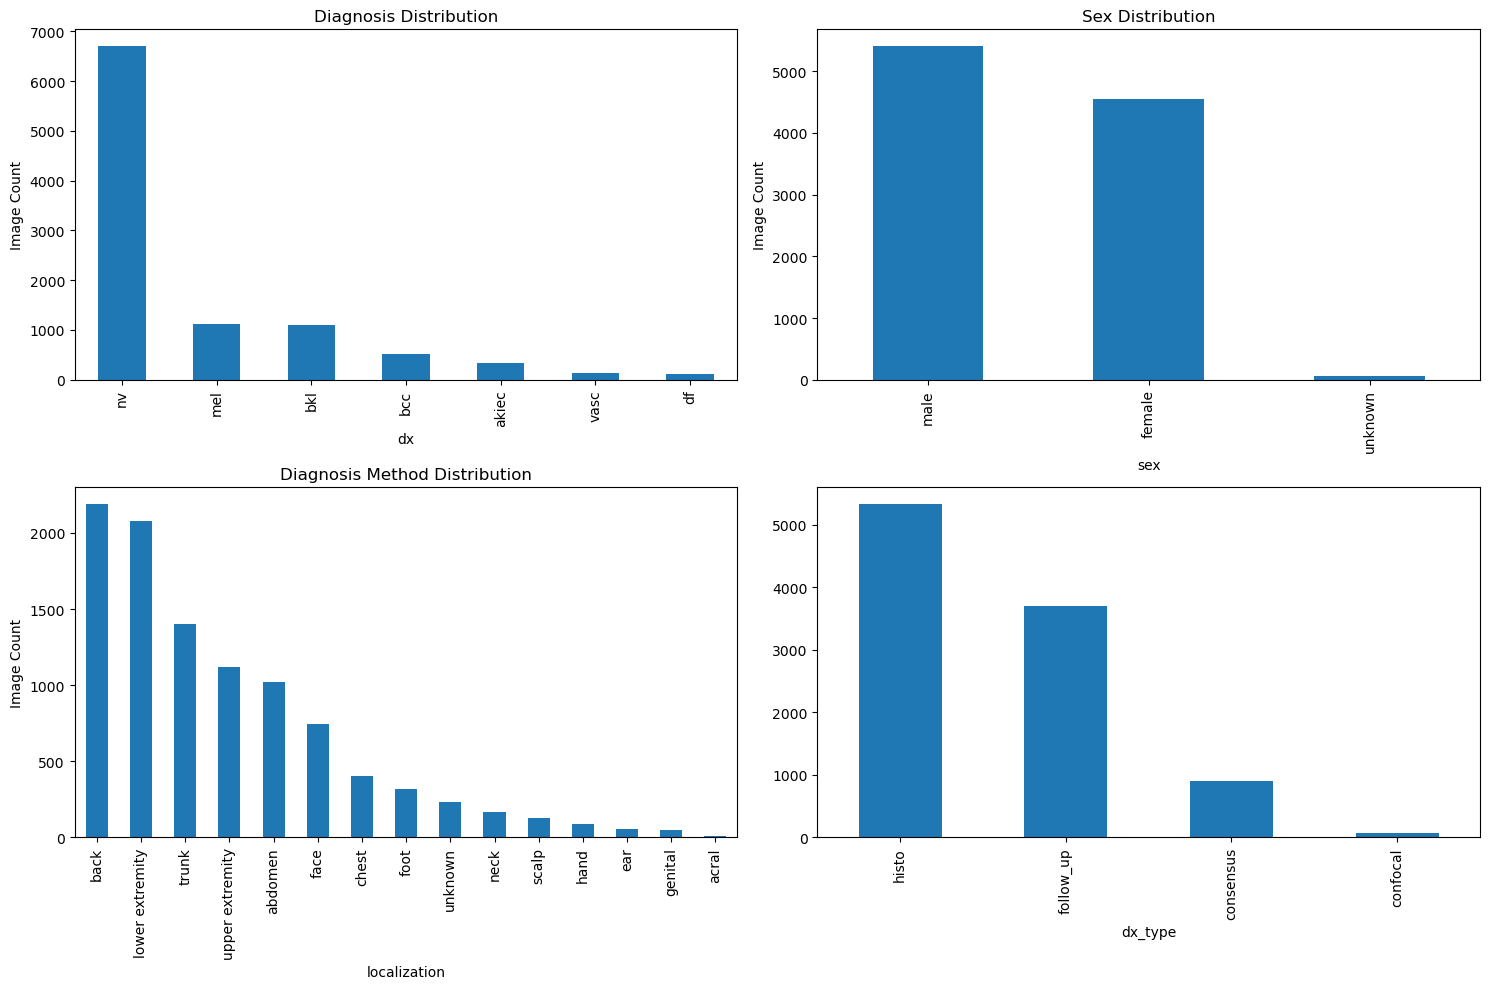

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [3]:
meta_data = pd.read_csv('data/HAM10000_metadata.csv')
fig = plt.figure(figsize=(15, 10))

#Diagnosis Distribution
ax1 = fig.add_subplot(221)
meta_data['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Diagnosis Distribution')
ax1.set_ylabel('Image Count')

#Sex Distribution
ax2 = fig.add_subplot(222)
meta_data['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Sex Distribution')
ax2.set_ylabel('Image Count')

#Localization Distribution 
ax3 = fig.add_subplot(223)
meta_data['localization'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Localization Distribution')
ax3.set_ylabel('Image Count')

#Diagnosis Method Distribution 
ax4 = fig.add_subplot(224)
meta_data['dx_type'].value_counts().plot(kind='bar', ax=ax4)
ax3.set_title('Diagnosis Method Distribution')
ax3.set_ylabel('Image Count')

plt.tight_layout()
plt.show()

#Info
print(meta_data.info())

##### Set up Hyper-Parameters

In [4]:
image_width = 224
image_height = 224
batch_size = 32
test_examples = 1012
validation_examples = 1008
train_examples = 7995

##### Initialize Model
- ResNet50 Pretrained

In [5]:
#Empty Model
resnet_model = K.models.Sequential()

#Pretrained Model
pretrained_model = K.applications.ResNet50(
    include_top=False, 
    input_shape=(224, 224, 3), 
    pooling='avg', 
    classes=7,
    weights='imagenet'
)

#Set Pretrained Model weights to untrainable
for layer in pretrained_model.layers:
    layer.trainable = False

#Amalgamate our final model
resnet_model.add(pretrained_model)
resnet_model.add(K.layers.Flatten())
resnet_model.add(K.layers.Dense(512, activation='relu'))
resnet_model.add(K.layers.Dense(7, activation='softmax'))

2024-01-15 18:42:54.990930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 18:42:55.029954: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 18:42:55.030190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24640391 (94.00 MB)
Trainable params: 1052679 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


##### Initialize Data Generators and Data Loaders

In [7]:
#Create Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    vertical_flip=True,
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [10]:
#Instantiate Data Generators into loaders
train_gen = train_datagen.flow_from_directory(
    "data/reorganized_train",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
test_gen = test_datagen.flow_from_directory(
    "data/reorganized_test",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)
validation_gen = validation_datagen.flow_from_directory(
    "data/reorganized_validation",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

Found 7995 images belonging to 7 classes.
Found 1012 images belonging to 7 classes.
Found 1008 images belonging to 7 classes.


##### Establish special metrics to handle testing of a skewed dataset
- Categorical Accuracy
- Precision
- Recall

In [14]:
METRICS = [
    K.metrics.CategoricalAccuracy(name="accuracy"),
    K.metrics.Precision(name="precision"),
    K.metrics.Recall(name="recall"),
    K.metrics.AUC(name="auc")
]

In [15]:
resnet_model.compile(
    optimizer=K.optimizers.Adam(learning_rate=3e-4),
    loss = [K.losses.CategoricalCrossentropy(from_logits=False)],
    metrics = METRICS
    )

##### Train the Model according to Hyper-Parameters.
-Currently facing Kernel Crash due to incorrect installation of tensorflow.

In [16]:
resnet_model.fit(
    train_gen,
    epochs=1,
    steps_per_epoch=train_examples//batch_size,
    validation_data=validation_gen,
    validation_steps=validation_examples//batch_size
)

249/249 [==============================] - 115s 446ms/step - loss: 1.0326 - accuracy: 0.6750 - precision: 0.7298 - recall: 0.6084 - auc: 0.9062 - val_loss: 1.0073 - val_accuracy: 0.6794 - val_precision: 0.7450 - val_recall: 0.6069 - val_auc: 0.9135


In [17]:
resnet_model.evaluate(validation_gen)
resnet_model.evaluate(test_gen)

32/32 [==============================] - 8s 251ms/step - loss: 1.0080 - accuracy: 0.6779 - precision: 0.7405 - recall: 0.6176 - auc: 0.9137


[1.0079981088638306,
 0.6778656244277954,
 0.7405213117599487,
 0.6175889372825623,
 0.9137330651283264]